In [1]:
import random
import gym
import numpy as np
from collections import deque
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
import keras
import csv
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score
from apscheduler.schedulers.background import BackgroundScheduler
import datetime
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
import sys, os
sys.path.insert(0, os.path.abspath('..'))
#from apis.getcpuinfo import cpuinfo 
from apis.getcpuinfonoscaling import cpuinfo 

In [3]:
# Definition for the agent
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95    # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.95
        self.learning_rate = 0.001
        self.model = self._build_model()

    def _build_model(self):
        # Neural Network for Deep-Q learning Model
        model = Sequential()
        model.add(Dense(24, input_dim=self.state_size, activation='relu'))
        model.add(Dense(12, activation='relu'))
        model.add(Dense(6, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse',
                      optimizer=Adam(lr=self.learning_rate))
        print(model.summary())
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state, is_train=True):
        if is_train and np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])  # returns action

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = (reward + self.gamma *
                          np.amax(self.model.predict(next_state)[0]))
            target_f = self.model.predict(state)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def load(self, name):
        self.model.load_weights(name)

    def save(self, name):
        self.model.save_weights(name)

In [4]:
# Definition for the environment
class Environment:
    def __init__(self, data, expected):
        self.counter = 0
        self.window = 50
        self.data = data
        self.expected = expected
        
    def reset(self):
        # return the initial state
        state = self.data[0]
        self.counter = 0
        return state
    
    def get_reward(self, action):
        if np.argmax(self.expected[self.counter - 1]) != action:
            return -1
        return 1

    def step(self, action):
        # use the specified action to get the next state
        self.counter += 1
        done = False
        next_state = self.data[self.counter]
        reward = self.get_reward(action)
        if (self.counter + 1 == len(self.data)):
            done = True
        return next_state, reward, done

In [5]:
# Settings for training or testing
window = 50
state_size = window
action_size = 3 # 1, 0 and -1

batch_size = 100
EPISODES = 1500

In [6]:
# Testing the agent
# env = Environment(X_test, y_test)
# action_list = []
# agent = DQNAgent(state_size, action_size)
# agent.load("./save/dqn-93.h5")
# done = False
# for e in range(1):
#     state = env.reset()
#     state = np.reshape(state, [1, state_size])
#     while True:
#         action = agent.act(state, False)
#         action_list.append(action)
#         if done:
#             break
#         next_state, reward, done = env.step(action)
#         next_state = np.reshape(next_state, [1, state_size])
#         state = next_state

In [7]:
predict_dict = {0:0, 1:1, 2:-1}

In [8]:
def appendToList(oldList,newList,maxLength):
    #append to the new entries
    #oldList = np.insert(oldList,0,np.array([newList]),axis = 0)
    oldList = np.append(oldList,np.array([newList]),axis = 0)
    #Remove oldest row if there are more than 50 entries
    if(oldList.shape[0]>maxLength):
        oldList = oldList[1:,:]
    return oldList

def getPredictionsForOneTimeStep(model,usageList,maxLengthParam):
    currUsageList = cpuinfo()
    for i in range(len(currUsageList)):
        currUsageList[i] /= 100.0
    updatedList = appendToList(usageList,currUsageList,maxLengthParam)
    predictions = []
    predDict = {0:0,1:1,2:-1}
    for i in range(updatedList.shape[1]): 
        if updatedList.shape[0]==maxLengthParam:
            modelOutput = model.predict(np.reshape(updatedList[:,i], [1, state_size]))
            #modelOutput = model.predict(np.expand_dims(np.expand_dims(updatedList[:,i],axis = 1),axis = 0))
            #print(modelOutput)
            modelPrediction = predDict[np.argmax(modelOutput)]
            predictions.append(modelPrediction)
        else:
            predictions.append(0)
    return predictions, updatedList


def getRightOutputs(usageList,minThreshold, maxThreshold):
    currList = usageList[0,:]
    for i in range(len(currList)):
        currList[i] *= 100.0
    print(currList)
    target = []
    for i in range(usageList.shape[1]):
        if currList[i] > maxThreshold:# Scale Up
            #print("MaxThres ",maxThreshold," ",currList[i])
            target.append(1)
        elif currList[i] < minThreshold: # Scale Down
            #print("MinThres ",minThreshold," ",currList[i])
            target.append(-1)
        else:
            #print("Same ",currList[i])
            target.append(0)  #Remain same
    return target     

def callAPIWithPredictions(predictions,URL):
    headers = {
        'Content-Type': 'application/json',
    }
    data = '{"predictions":['+ ','.join(str(num) for num in predictions) +']}'
    print(data)
    response = requests.post(URL, headers=headers, data=data)
       
class Prediction():
    def __init__(self, model, maxLengthParam,containerCount,minThreshold, maxThreshold):
        self.usageArray = np.empty(shape = (0,containerCount))
        self.correctOutputArray = np.empty(shape = (0,containerCount))
        self.predictionsArray = np.empty(shape = (0,containerCount))
        self.model = model
        self.maxLengthParam = maxLengthParam
        self.minThreshold = minThreshold
        self.maxThreshold = maxThreshold
        self.lastPredictions = [-1, -1, -1, -1]
        self.accuracy_list = []
    
    def generatePredictions(self): 
        predictions,self.usageArray = getPredictionsForOneTimeStep(self.model,self.usageArray,self.maxLengthParam)       
        self.predictionsArray = appendToList(self.predictionsArray, predictions, self.maxLengthParam)
        if (self.usageArray.shape[0]==self.maxLengthParam):
            correctOutputsList = getRightOutputs(self.usageArray,self.minThreshold, self.maxThreshold)
            self.correctOutputArray = appendToList(self.correctOutputArray, correctOutputsList, self.maxLengthParam)
            print("Last predictions: ", self.lastPredictions)
            print("Last expected outputs: ",correctOutputsList) 
            accuracy = accuracy_score(self.lastPredictions,correctOutputsList)
            print("Last accuracy: ", accuracy)
            self.accuracy_list.append(accuracy)
            #print("Predictions: ",predictions)            
            #callAPIWithPredictions(predictions,"http://152.46.16.189:5000/changeVCPU")
            #callAPIWithPredictions(predictions,"http://152.46.19.80:5000/changeVCPU")
            self.lastPredictions = predictions

In [9]:
def getDQNModel(maxLengthParam):
    model = Sequential()
    model.add(Dense(24, input_dim=maxLengthParam, activation='relu'))
    model.add(Dense(12, activation='relu'))
    model.add(Dense(6, activation='relu'))
    model.add(Dense(3, activation='linear'))
    model.compile(loss='mse',
                  optimizer=Adam(lr=0.001))
    if os.path.isfile("dqn30.h5"):
        model.load_weights("dqn30.h5")
        return model
    else:
        print("Unable to find trained model")
        return -1;

In [10]:
def plot_line_graph(data):
    fig = plt.gcf()
    #fig.set_size_inches(18.5, 10.5)
    t = np.arange(0.01, len(data), 1)
    plt.plot(t, data) 
    # make these tick labels visible
    plt.show()

In [11]:
temp = cpuinfo()

In [12]:
dqn_model = getDQNModel(50)
temp = cpuinfo()
test = Prediction(dqn_model,50,len(temp),30,70)
for i in range(50):
    test.generatePredictions()

Instructions for updating:
Colocations handled automatically by placer.
[28.261303  26.8243259 40.547964  67.0943696]
Last predictions:  [-1, -1, -1, -1]
Last expected outputs:  [-1, -1, 0, 0]
Last accuracy:  0.5


In [13]:
sched = BackgroundScheduler()
sched.add_job(test.generatePredictions, 'interval', seconds=2)
sched.start()
print(datetime.datetime.now())

2019-04-25 12:48:30.624701


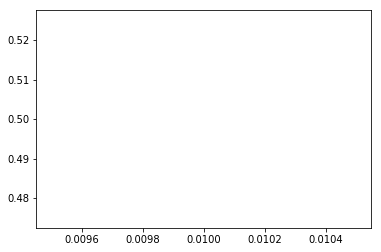

In [14]:
plot_line_graph(test.accuracy_list)

In [15]:
#sched.shutdown() # shutdown the scheduler

In [16]:
print(sum(test.accuracy_list) / len(test.accuracy_list))

0.5
[28.261303  26.8243259 40.547964  91.5496734]
Last predictions:  [0, 0, 0, 0]
Last expected outputs:  [-1, -1, 0, 1]
Last accuracy:  0.25
[28.261303  26.8243259 40.547964  91.5496734]
Last predictions:  [0, 0, 0, 1]
Last expected outputs:  [-1, -1, 0, 1]
Last accuracy:  0.5
[28.261303  26.8243259 40.547964  91.5496734]
Last predictions:  [0, 0, 0, 0]
Last expected outputs:  [-1, -1, 0, 1]
Last accuracy:  0.25
[28.261303  26.9557609 39.1207523 91.5496734]
Last predictions:  [0, 0, 0, 1]
Last expected outputs:  [-1, -1, 0, 1]
Last accuracy:  0.5
[28.261303  26.9557609 39.1207523 91.5496734]
Last predictions:  [0, 0, 0, 0]
Last expected outputs:  [-1, -1, 0, 1]
Last accuracy:  0.25
[28.261303  26.9557609 39.1207523 84.9551973]
Last predictions:  [0, 0, 0, 0]
Last expected outputs:  [-1, -1, 0, 1]
Last accuracy:  0.25
[26.1364707 26.9557609 39.1207523 84.9551973]
Last predictions:  [0, 0, 0, 0]
Last expected outputs:  [-1, -1, 0, 1]
Last accuracy:  0.25
[26.1364707 26.9557609 39.120752

[26.2350462 30.2203248 42.3423074 94.4663801]
Last predictions:  [0, 0, 0, 1]
Last expected outputs:  [-1, 0, 0, 1]
Last accuracy:  0.75
[34.9693378 36.9532006 52.57878   91.1065654]
Last predictions:  [0, 0, 0, 1]
Last expected outputs:  [0, 0, 0, 1]
Last accuracy:  1.0
[ 32.0065773  43.2281055  57.6653227 105.1819083]
Last predictions:  [0, 0, 0, 1]
Last expected outputs:  [0, 0, 0, 1]
Last accuracy:  1.0
[26.9749756 31.2055348 46.7274565 86.0032753]
Last predictions:  [0, 0, 0, 0]
Last expected outputs:  [-1, 0, 0, 1]
Last accuracy:  0.5
[33.2193126 26.3786039 53.190551  69.7239847]
Last predictions:  [0, 0, 0, 1]
Last expected outputs:  [0, -1, 0, 0]
Last accuracy:  0.5
[33.6766356 30.2078675 48.8582757 84.399406 ]
Last predictions:  [0, 0, 0, 0]
Last expected outputs:  [0, 0, 0, 1]
Last accuracy:  0.75
[27.6121982 26.4370237 39.5285668 82.6547749]
Last predictions:  [0, 0, 0, 1]
Last expected outputs:  [-1, -1, 0, 1]
Last accuracy:  0.5
[ 34.5603916  49.7646152  47.3250705 104.533

[27.938882  28.5968738 37.2340455 90.3454147]
Last predictions:  [0, 0, 0, 0]
Last expected outputs:  [-1, -1, 0, 1]
Last accuracy:  0.25
[27.8883359 27.3333074 47.9365419 74.989891 ]
Last predictions:  [0, 0, 0, 0]
Last expected outputs:  [-1, -1, 0, 1]
Last accuracy:  0.25
[34.9498072 28.9533307 48.805047  88.2789664]
Last predictions:  [0, 0, 0, 0]
Last expected outputs:  [0, -1, 0, 1]
Last accuracy:  0.5
[32.7878028 29.5779166 46.9554817 81.8128128]
Last predictions:  [-1, -1, 0, 0]
Last expected outputs:  [0, -1, 0, 1]
Last accuracy:  0.5
[30.5578738 47.6738542 40.0452602 77.1399919]
Last predictions:  [0, 0, 0, 0]
Last expected outputs:  [0, 0, 0, 1]
Last accuracy:  0.75
[28.934104  28.7640813 41.840277  73.7274933]
Last predictions:  [0, 0, 0, 1]
Last expected outputs:  [-1, -1, 0, 1]
Last accuracy:  0.5
[ 30.3638644  27.4153775  46.8711159 101.8270061]
Last predictions:  [0, 0, 0, 1]
Last expected outputs:  [0, -1, 0, 1]
Last accuracy:  0.75
[31.8235067 29.1773841 46.9993261 79

[ 41.4918439  29.5290679  62.3381266 105.9014498]
Last predictions:  [0, 0, 0, 0]
Last expected outputs:  [0, -1, 0, 1]
Last accuracy:  0.5
[34.0005571 28.4537592 50.670959  76.3884019]
Last predictions:  [0, 0, 0, 1]
Last expected outputs:  [0, -1, 0, 1]
Last accuracy:  0.75
[ 29.8684217  31.5004176  55.0143112 104.1156286]
Last predictions:  [0, 0, 0, 0]
Last expected outputs:  [-1, 0, 0, 1]
Last accuracy:  0.5
[ 38.121711   32.1777915  53.5042809 103.2702817]
Last predictions:  [0, 0, 0, 0]
Last expected outputs:  [0, 0, 0, 1]
Last accuracy:  0.75
[38.3926952 31.7756873 55.0996873 94.1316401]
Last predictions:  [0, 0, 0, 0]
Last expected outputs:  [0, 0, 0, 1]
Last accuracy:  0.75
[31.2776909 31.048167  48.5127907 72.2599784]
Last predictions:  [0, 0, 0, 1]
Last expected outputs:  [0, 0, 0, 1]
Last accuracy:  1.0
[28.3098389 28.7001697 45.6939348 76.6332438]
Last predictions:  [0, 0, 0, 1]
Last expected outputs:  [-1, -1, 0, 1]
Last accuracy:  0.5
[33.1237531 28.6123206 47.8503212 6

[36.0462328 29.4312962 50.9395357 88.7324971]
Last predictions:  [0, 0, 0, 0]
Last expected outputs:  [0, -1, 0, 1]
Last accuracy:  0.5
[31.0796589 28.6227473 51.4730247 87.3721396]
Last predictions:  [0, 0, 0, 1]
Last expected outputs:  [0, -1, 0, 1]
Last accuracy:  0.75
[35.0897568 41.3625984 39.4240069 97.4961175]
Last predictions:  [0, 0, 0, 1]
Last expected outputs:  [0, 0, 0, 1]
Last accuracy:  1.0
[28.6761948 29.6182993 50.2188056 86.2789316]
Last predictions:  [0, 0, 0, 0]
Last expected outputs:  [-1, -1, 0, 1]
Last accuracy:  0.25
[32.6355859 29.381705  46.6876536 73.7512785]
Last predictions:  [0, 0, 0, 1]
Last expected outputs:  [0, -1, 0, 1]
Last accuracy:  0.75
[32.9246523 29.5117102 48.1448254 99.1758228]
Last predictions:  [0, 0, 0, 0]
Last expected outputs:  [0, -1, 0, 1]
Last accuracy:  0.5
[25.8492773 28.0513433 42.0093336 56.1543802]
Last predictions:  [0, 0, 0, 1]
Last expected outputs:  [-1, -1, 0, 0]
Last accuracy:  0.25
[39.2186314 59.2927495 53.1110909 91.158458

[ 31.0706188  25.7256054  42.5724381 105.7659764]
Last predictions:  [0, 0, 0, 1]
Last expected outputs:  [0, -1, 0, 1]
Last accuracy:  0.75
[24.639535  28.1570795 34.3465612 96.3677212]
Last predictions:  [0, 0, 0, 0]
Last expected outputs:  [-1, -1, 0, 1]
Last accuracy:  0.25
[ 32.2294346  27.9972104  52.8979488 106.2820584]
Last predictions:  [0, 0, 0, 1]
Last expected outputs:  [0, -1, 0, 1]
Last accuracy:  0.75
[32.541194  32.3183904 41.2999875 76.6844433]
Last predictions:  [0, 0, 0, 0]
Last expected outputs:  [0, 0, 0, 1]
Last accuracy:  0.75
[27.1995663 37.2041903 48.1263909 92.3227739]
Last predictions:  [0, 0, 0, 1]
Last expected outputs:  [-1, 0, 0, 1]
Last accuracy:  0.75
[25.3288248 21.755934  41.3085194 70.6919304]
Last predictions:  [0, 0, 0, 1]
Last expected outputs:  [-1, -1, 0, 1]
Last accuracy:  0.5
[22.8116132 19.8828189 33.0804341 45.5392014]
Last predictions:  [0, 0, 0, 1]
Last expected outputs:  [-1, -1, 0, 0]
Last accuracy:  0.25
[ 27.8754833  26.5505867  56.077

[25.8265584 23.4876011 38.586448  73.3923064]
Last predictions:  [0, -1, 0, 0]
Last expected outputs:  [-1, -1, 0, 1]
Last accuracy:  0.5
[33.1341723 29.2720551 48.5961833 69.5226662]
Last predictions:  [0, -1, 0, 1]
Last expected outputs:  [0, -1, 0, 0]
Last accuracy:  0.75
[ 35.3914142  33.355668   53.2990983 123.573793 ]
Last predictions:  [0, 0, 0, 0]
Last expected outputs:  [0, 0, 0, 1]
Last accuracy:  0.75
[38.2935232 26.3840023 50.673748  75.4679538]
Last predictions:  [0, 0, 0, 1]
Last expected outputs:  [0, -1, 0, 1]
Last accuracy:  0.75
[ 32.252238   28.5677226  48.0751034 112.8934619]
Last predictions:  [0, 0, 0, 1]
Last expected outputs:  [0, -1, 0, 1]
Last accuracy:  0.75
[34.1644399 24.4267434 44.4598753 83.7414966]
Last predictions:  [0, 0, 0, 1]
Last expected outputs:  [0, -1, 0, 1]
Last accuracy:  0.75
[24.5722794 48.6610312 50.0135766 69.2094851]
Last predictions:  [0, 0, 0, 0]
Last expected outputs:  [-1, 0, 0, 0]
Last accuracy:  0.75
[37.1336128 27.0199756 36.287008

[ 32.9409665  35.4821656  43.6648011 121.4407899]
Last predictions:  [0, 0, 0, 0]
Last expected outputs:  [0, 0, 0, 1]
Last accuracy:  0.75
[32.1886673 28.7282549 50.6049817 87.9207026]
Last predictions:  [0, 0, 0, 1]
Last expected outputs:  [0, -1, 0, 1]
Last accuracy:  0.75
[29.6574531 24.9363587 41.5693543 85.4767242]
Last predictions:  [0, 0, 0, 0]
Last expected outputs:  [-1, -1, 0, 1]
Last accuracy:  0.25
[ 28.4086557  29.7366328  44.5113822 101.913414 ]
Last predictions:  [0, -1, 0, 1]
Last expected outputs:  [-1, -1, 0, 1]
Last accuracy:  0.75
[ 35.822418   35.92214    53.553888  102.8807183]
Last predictions:  [0, 0, 0, 1]
Last expected outputs:  [0, 0, 0, 1]
Last accuracy:  1.0
[34.2427939 26.1887002 51.5781186 92.3561112]
Last predictions:  [0, 0, 0, 0]
Last expected outputs:  [0, -1, 0, 1]
Last accuracy:  0.5
[34.9864428 30.1934076 56.4852292 94.7021852]
Last predictions:  [0, 0, 0, 0]
Last expected outputs:  [0, 0, 0, 1]
Last accuracy:  0.75
[31.3376387 30.3066065 52.04673

[33.2552195 24.9587871 53.9972004 82.0671449]
Last predictions:  [0, 0, 0, 0]
Last expected outputs:  [0, -1, 0, 1]
Last accuracy:  0.5
[29.5800258 28.6778768 46.0757679 73.3296476]
Last predictions:  [0, 0, 0, 1]
Last expected outputs:  [-1, -1, 0, 1]
Last accuracy:  0.5
[26.157871  28.9580581 40.9175896 68.0800098]
Last predictions:  [0, 0, 0, 1]
Last expected outputs:  [-1, -1, 0, 0]
Last accuracy:  0.25
[24.3329961 26.3328558 42.6369568 61.1371574]
Last predictions:  [0, 0, 0, 1]
Last expected outputs:  [-1, -1, 0, 0]
Last accuracy:  0.25
[28.7499007 23.4730058 48.310923  90.1742742]
Last predictions:  [0, 0, 0, 0]
Last expected outputs:  [-1, -1, 0, 1]
Last accuracy:  0.25
[ 25.7052645  23.8085627  40.0192243 117.0194973]
Last predictions:  [0, 0, 0, 0]
Last expected outputs:  [-1, -1, 0, 1]
Last accuracy:  0.25
[28.8575748 31.8170654 47.0493798 92.028845 ]
Last predictions:  [0, 0, 0, 0]
Last expected outputs:  [-1, 0, 0, 1]
Last accuracy:  0.5
[34.4498086 33.281407  49.4958617 9

[33.6385243 29.4711365 50.1665163 55.4226044]
Last predictions:  [0, 0, 0, 0]
Last expected outputs:  [0, -1, 0, 0]
Last accuracy:  0.75
[26.7852135 35.7092374 46.3391627 83.1348721]
Last predictions:  [0, 0, 0, 1]
Last expected outputs:  [-1, 0, 0, 1]
Last accuracy:  0.75
[ 32.8126672  30.2230262  48.7144638 110.8777324]
Last predictions:  [0, 0, 0, 1]
Last expected outputs:  [0, 0, 0, 1]
Last accuracy:  1.0
[31.9457672 32.632642  46.0252133 70.170394 ]
Last predictions:  [0, 0, 0, 0]
Last expected outputs:  [0, 0, 0, 1]
Last accuracy:  0.75
[30.2929376 29.3315612 42.59801   59.1785495]
Last predictions:  [0, 0, 0, 1]
Last expected outputs:  [0, -1, 0, 0]
Last accuracy:  0.5
[26.7266087 29.7672341 42.2421671 87.2695347]
Last predictions:  [0, 0, 0, 0]
Last expected outputs:  [-1, -1, 0, 1]
Last accuracy:  0.25
[ 39.5446845  52.3087239  48.483972  103.960336 ]
Last predictions:  [0, 0, 0, 0]
Last expected outputs:  [0, 0, 0, 1]
Last accuracy:  0.75
[31.250571  30.553487  44.4977289 70.

[39.4569622 35.1687804 43.4904826 81.9527879]
Last predictions:  [0, 0, 0, 1]
Last expected outputs:  [0, 0, 0, 1]
Last accuracy:  1.0
[32.3846912 27.2476238 55.3944718 74.1029677]
Last predictions:  [0, 0, 0, 1]
Last expected outputs:  [0, -1, 0, 1]
Last accuracy:  0.75
[31.5558403 24.4231431 41.4133092 83.7622212]
Last predictions:  [0, 0, 0, 1]
Last expected outputs:  [0, -1, 0, 1]
Last accuracy:  0.75
[21.9172186 25.2595741 32.9084561 80.1993744]
Last predictions:  [0, 0, 0, 1]
Last expected outputs:  [-1, -1, 0, 1]
Last accuracy:  0.5
[ 18.453049   26.0602646  36.0894457 102.244455 ]
Last predictions:  [0, 0, 0, 0]
Last expected outputs:  [-1, -1, 0, 1]
Last accuracy:  0.25
[26.6165165 28.8242674 54.4069451 69.8408461]
Last predictions:  [0, 0, 0, 0]
Last expected outputs:  [-1, -1, 0, 0]
Last accuracy:  0.5
[33.6588572 27.4712025 43.1843662 98.3013308]
Last predictions:  [0, 0, 0, 1]
Last expected outputs:  [0, -1, 0, 1]
Last accuracy:  0.75
[36.0542853 32.5640828 57.4897716 87.3

[27.0423585 31.2315288 44.2801313 92.5533501]
Last predictions:  [0, 0, 0, 0]
Last expected outputs:  [-1, 0, 0, 1]
Last accuracy:  0.5
[23.4372166 26.7428274 41.0743524 57.132124 ]
Last predictions:  [0, 0, 0, 1]
Last expected outputs:  [-1, -1, 0, 0]
Last accuracy:  0.25
[34.7294488 28.5901958 48.537847  80.3875748]
Last predictions:  [0, 0, 0, 0]
Last expected outputs:  [0, -1, 0, 1]
Last accuracy:  0.5
[40.5559083 32.8105876 54.5393277 90.9412081]
Last predictions:  [0, 0, 0, 1]
Last expected outputs:  [0, 0, 0, 1]
Last accuracy:  1.0
[ 35.6017342  28.2572143  51.7414078 125.9890293]
Last predictions:  [0, 0, 0, 1]
Last expected outputs:  [0, -1, 0, 1]
Last accuracy:  0.75
[32.5333796 28.1636712 46.2850325 80.959829 ]
Last predictions:  [0, 0, 0, 1]
Last expected outputs:  [0, -1, 0, 1]
Last accuracy:  0.75
[36.5121174 31.2510583 47.3918167 85.6497314]
Last predictions:  [0, 0, 0, 1]
Last expected outputs:  [0, 0, 0, 1]
Last accuracy:  1.0
[ 32.5145127  26.1880822  57.1662636 100.0

[ 23.8861421  30.0518836  43.551039  109.0880004]
Last predictions:  [0, 0, 0, 0]
Last expected outputs:  [-1, 0, 0, 1]
Last accuracy:  0.5
[ 38.7352162  48.6378727  42.4296354 115.3678637]
Last predictions:  [0, 0, 0, 1]
Last expected outputs:  [0, 0, 0, 1]
Last accuracy:  1.0
[34.8944572 31.3038184 42.5171644 91.7220174]
Last predictions:  [0, -1, 0, 0]
Last expected outputs:  [0, 0, 0, 1]
Last accuracy:  0.5
[27.5270113 28.2896098 39.007322  83.8820601]
Last predictions:  [0, 0, 0, 1]
Last expected outputs:  [-1, -1, 0, 1]
Last accuracy:  0.5
[24.2236915 25.906384  43.3066557 71.4759848]
Last predictions:  [0, 0, 0, 1]
Last expected outputs:  [-1, -1, 0, 1]
Last accuracy:  0.5
[25.5025703 21.9277488 32.9489934 51.7974902]
Last predictions:  [0, 0, 0, 1]
Last expected outputs:  [-1, -1, 0, 0]
Last accuracy:  0.25
[28.9311655 31.1515933 47.521633  84.8571701]
Last predictions:  [0, 0, 0, 0]
Last expected outputs:  [-1, 0, 0, 1]
Last accuracy:  0.5
[29.7732858 45.3586636 44.6356072 95.

[32.719263  23.7818726 53.0382455 89.7009491]
Last predictions:  [0, 0, 0, 1]
Last expected outputs:  [0, -1, 0, 1]
Last accuracy:  0.75
[39.0914848 28.6346449 45.7007541 73.8182892]
Last predictions:  [0, 0, 0, 1]
Last expected outputs:  [0, -1, 0, 1]
Last accuracy:  0.75
[25.6649769 24.72028   41.9201358 98.1969173]
Last predictions:  [0, 0, 0, 1]
Last expected outputs:  [-1, -1, 0, 1]
Last accuracy:  0.5
[ 26.7310969  31.1994477  47.3976342 105.3040392]
Last predictions:  [0, 0, 0, 0]
Last expected outputs:  [-1, 0, 0, 1]
Last accuracy:  0.5
[35.829101  30.1753243 49.939854  79.4673458]
Last predictions:  [0, 0, 0, 1]
Last expected outputs:  [0, 0, 0, 1]
Last accuracy:  1.0
[ 39.2221419  33.5341336  54.7789459 119.0681229]
Last predictions:  [0, 0, 0, 0]
Last expected outputs:  [0, 0, 0, 1]
Last accuracy:  0.75
[41.3154464 29.0402134 45.2888386 98.4824228]
Last predictions:  [0, 0, 0, 1]
Last expected outputs:  [0, -1, 0, 1]
Last accuracy:  0.75
[26.0405314 28.375887  43.2174814 57.

[27.4247896 41.3387797 43.7711789 58.6255204]
Last predictions:  [0, 0, 0, 1]
Last expected outputs:  [-1, 0, 0, 0]
Last accuracy:  0.5
[34.8004346 34.1041729 47.6667881 87.2540012]
Last predictions:  [0, 0, 0, 0]
Last expected outputs:  [0, 0, 0, 1]
Last accuracy:  0.75
[27.4422062 33.6002492 45.1837479 82.0226152]
Last predictions:  [0, 0, 0, 0]
Last expected outputs:  [-1, 0, 0, 1]
Last accuracy:  0.5
[27.9181527 27.423564  43.8582888 85.7763105]
Last predictions:  [0, 0, 0, 0]
Last expected outputs:  [-1, -1, 0, 1]
Last accuracy:  0.25
[31.149623  29.3890998 54.7404669 90.4038645]
Last predictions:  [0, 0, 0, 1]
Last expected outputs:  [0, -1, 0, 1]
Last accuracy:  0.75
[ 39.0619754  51.0589775  48.3872196 129.2963763]
Last predictions:  [0, 0, 0, 1]
Last expected outputs:  [0, 0, 0, 1]
Last accuracy:  1.0
[26.1223563 29.7039289 44.5015768 81.9554005]
Last predictions:  [0, 0, 0, 1]
Last expected outputs:  [-1, -1, 0, 1]
Last accuracy:  0.5
[29.1923161 26.8840362 42.8556457 63.6346

[32.3076317 33.9536682 47.9391717 99.0563793]
Last predictions:  [0, 0, 0, 1]
Last expected outputs:  [0, 0, 0, 1]
Last accuracy:  1.0
[ 43.4407063  35.1789326  62.7917999 121.672188 ]
Last predictions:  [0, 0, 0, 1]
Last expected outputs:  [0, 0, 0, 1]
Last accuracy:  1.0
[33.4064377 52.4059909 54.5041627 96.0361503]
Last predictions:  [0, 0, 0, 1]
Last expected outputs:  [0, 0, 0, 1]
Last accuracy:  1.0
[29.5001904 31.9500573 51.6460834 93.4250641]
Last predictions:  [0, 0, 0, 1]
Last expected outputs:  [-1, 0, 0, 1]
Last accuracy:  0.75
[25.967925  24.1355026 48.7040026 58.3285588]
Last predictions:  [0, 0, 0, 1]
Last expected outputs:  [-1, -1, 0, 0]
Last accuracy:  0.25
[35.0226018 32.3885416 52.3679416 93.5207296]
Last predictions:  [0, 0, 0, 0]
Last expected outputs:  [0, 0, 0, 1]
Last accuracy:  0.75
[33.8925273 31.4485897 51.2976682 72.9746664]
Last predictions:  [0, 0, 0, 0]
Last expected outputs:  [0, 0, 0, 1]
Last accuracy:  0.75
[28.5495333 41.5534713 41.2462043 77.1055989

[32.5092281 28.8294632 50.5251885 88.7568528]
Last predictions:  [0, 0, 0, 1]
Last expected outputs:  [0, -1, 0, 1]
Last accuracy:  0.75
[33.2321459 28.9785315 49.0767421 86.3782986]
Last predictions:  [0, 0, 0, 1]
Last expected outputs:  [0, -1, 0, 1]
Last accuracy:  0.75
[ 32.8752695  34.1279217  51.8749215 105.1643841]
Last predictions:  [0, 0, 0, 0]
Last expected outputs:  [0, 0, 0, 1]
Last accuracy:  0.75
[ 29.87286    27.7689293  41.6717626 100.0888489]
Last predictions:  [0, 0, 0, 1]
Last expected outputs:  [-1, -1, 0, 1]
Last accuracy:  0.5
[ 38.7045192  32.0376818  56.7218016 137.1830699]
Last predictions:  [0, -1, 0, 1]
Last expected outputs:  [0, 0, 0, 1]
Last accuracy:  0.75
[ 35.6439996  34.6515174  52.6521015 113.9965231]
Last predictions:  [0, 0, 0, 1]
Last expected outputs:  [0, 0, 0, 1]
Last accuracy:  1.0
[ 34.0809574  34.0194292  55.135269  100.6661483]
Last predictions:  [0, 0, 0, 1]
Last expected outputs:  [0, 0, 0, 1]
Last accuracy:  1.0
[30.5482277 30.4493559 45.

[36.5298726 30.0473552 51.3460676 79.0962314]
Last predictions:  [0, 0, 0, 1]
Last expected outputs:  [0, 0, 0, 1]
Last accuracy:  1.0
[28.713522  41.6745613 43.8203444 56.1287518]
Last predictions:  [0, 0, 0, 1]
Last expected outputs:  [-1, 0, 0, 0]
Last accuracy:  0.5
[40.9067217 32.3723156 40.9726683 96.6999668]
Last predictions:  [0, 0, 0, 0]
Last expected outputs:  [0, 0, 0, 1]
Last accuracy:  0.75
[27.6840979 31.118873  52.1748961 75.985838 ]
Last predictions:  [0, 0, 0, 0]
Last expected outputs:  [-1, 0, 0, 1]
Last accuracy:  0.5
[27.3601797 29.0818037 41.0192882 62.9077692]
Last predictions:  [0, 0, 0, 0]
Last expected outputs:  [-1, -1, 0, 0]
Last accuracy:  0.5
[26.189397  25.9366236 42.4108537 85.2756739]
Last predictions:  [0, 0, 0, 1]
Last expected outputs:  [-1, -1, 0, 1]
Last accuracy:  0.5
[30.5117872 28.2795237 43.397983  82.3479025]
Last predictions:  [0, 0, 0, 0]
Last expected outputs:  [0, -1, 0, 1]
Last accuracy:  0.5
[37.592413  33.8116724 52.296099  82.3174179]
L

[21.0029536 26.918288  41.2395382 74.0520581]
Last predictions:  [0, 0, 0, 0]
Last expected outputs:  [-1, -1, 0, 1]
Last accuracy:  0.25
[37.248124  29.1071456 56.5930443 96.9395847]
Last predictions:  [0, 0, 0, 1]
Last expected outputs:  [0, -1, 0, 1]
Last accuracy:  0.75
[29.3169675 22.8617009 49.3212623 80.4620244]
Last predictions:  [0, 0, 0, 1]
Last expected outputs:  [-1, -1, 0, 1]
Last accuracy:  0.5
[ 26.4832902  25.8504041  41.5100204 108.4085439]
Last predictions:  [0, 0, 0, 0]
Last expected outputs:  [-1, -1, 0, 1]
Last accuracy:  0.25
[ 34.3827782  35.0253535  48.0883218 100.7509758]
Last predictions:  [0, 0, 0, 1]
Last expected outputs:  [0, 0, 0, 1]
Last accuracy:  1.0
[31.872536  32.6124367 45.1810512 84.3925902]
Last predictions:  [0, 0, 0, 1]
Last expected outputs:  [0, 0, 0, 1]
Last accuracy:  1.0
[28.910492  27.0019293 52.881015  72.7157972]
Last predictions:  [0, 0, 0, 1]
Last expected outputs:  [-1, -1, 0, 1]
Last accuracy:  0.5
[ 27.2231383  28.0903645  41.108825

[ 34.8193005  44.038979   53.404433  102.5643226]
Last predictions:  [0, 0, 0, 1]
Last expected outputs:  [0, 0, 0, 1]
Last accuracy:  1.0
[ 33.181886   38.0219861  54.8657667 114.5171027]
Last predictions:  [0, 0, 0, 0]
Last expected outputs:  [0, 0, 0, 1]
Last accuracy:  0.75
[26.9232981 22.619781  39.9580899 67.393923 ]
Last predictions:  [0, 0, 0, 1]
Last expected outputs:  [-1, -1, 0, 0]
Last accuracy:  0.25
[26.8121847 27.3314786 48.4427572 75.4681939]
Last predictions:  [0, 0, 0, 0]
Last expected outputs:  [-1, -1, 0, 1]
Last accuracy:  0.25
[24.3267832 25.3254576 36.9154184 71.7969666]
Last predictions:  [0, 0, 0, 0]
Last expected outputs:  [-1, -1, 0, 1]
Last accuracy:  0.25
[ 31.1709316  29.4340202  49.3821096 108.0145338]
Last predictions:  [0, 0, 0, 1]
Last expected outputs:  [0, -1, 0, 1]
Last accuracy:  0.75
[36.6775883 28.2857929 57.4991313 87.6213454]
Last predictions:  [0, 0, 0, 0]
Last expected outputs:  [0, -1, 0, 1]
Last accuracy:  0.5
[ 38.7316873  27.8213647  34.5

[25.6883707 27.563232  40.7478519 89.1819132]
Last predictions:  [0, 0, 0, 1]
Last expected outputs:  [-1, -1, 0, 1]
Last accuracy:  0.5
[28.7253125 28.7230423 48.1467644 84.0703981]
Last predictions:  [0, 0, 0, 0]
Last expected outputs:  [-1, -1, 0, 1]
Last accuracy:  0.25
[35.4307615 48.634638  55.07425   98.0113564]
Last predictions:  [0, 0, 0, 1]
Last expected outputs:  [0, 0, 0, 1]
Last accuracy:  1.0
[31.057996  34.657958  44.8451136 85.4073328]
Last predictions:  [0, 0, 0, 1]
Last expected outputs:  [0, 0, 0, 1]
Last accuracy:  1.0
[33.3150922 29.9515462 58.0838293 90.5480443]
Last predictions:  [0, 0, 0, 0]
Last expected outputs:  [0, -1, 0, 1]
Last accuracy:  0.5
[32.1639854 28.7457221 49.9098582 87.3766089]
Last predictions:  [0, 0, 0, 0]
Last expected outputs:  [0, -1, 0, 1]
Last accuracy:  0.5
[27.2301243 27.3107108 38.8392382 75.4523474]
Last predictions:  [0, 0, 0, 1]
Last expected outputs:  [-1, -1, 0, 1]
Last accuracy:  0.5
[27.6101695 45.6042186 41.4419259 83.7413692]


[ 35.6632889  33.9560469  54.7568959 166.2402697]
Last predictions:  [0, 0, 0, 0]
Last expected outputs:  [0, 0, 0, 1]
Last accuracy:  0.75
[25.6496009 28.4512663 46.8353281 73.987481 ]
Last predictions:  [0, 0, 0, 0]
Last expected outputs:  [-1, -1, 0, 1]
Last accuracy:  0.25
[34.2041959 24.987116  40.8277604 99.08265  ]
Last predictions:  [0, 0, 0, 1]
Last expected outputs:  [0, -1, 0, 1]
Last accuracy:  0.75
[29.8275241 45.8198399 52.2730263 73.8459739]
Last predictions:  [0, 0, 0, 0]
Last expected outputs:  [-1, 0, 0, 1]
Last accuracy:  0.5
[28.7272865 28.1730046 35.0573194 81.6245329]
Last predictions:  [0, 0, 0, 0]
Last expected outputs:  [-1, -1, 0, 1]
Last accuracy:  0.25
[32.1121094 29.7022646 51.9066304 86.8380402]
Last predictions:  [0, 0, 0, 1]
Last expected outputs:  [0, -1, 0, 1]
Last accuracy:  0.75
[27.5876117 26.6301355 42.9120711 68.7115803]
Last predictions:  [0, 0, 0, 1]
Last expected outputs:  [-1, -1, 0, 0]
Last accuracy:  0.25
[33.1362396 30.0982081 57.7022027 99

[30.2511387 32.8850506 51.9934557 89.2855674]
Last predictions:  [0, 0, 0, 1]
Last expected outputs:  [0, 0, 0, 1]
Last accuracy:  1.0
[31.1227996 31.1726141 43.816569  97.058586 ]
Last predictions:  [0, 0, 0, 0]
Last expected outputs:  [0, 0, 0, 1]
Last accuracy:  0.75
[33.2464931 35.2838919 57.8399713 95.3034055]
Last predictions:  [0, 0, 0, 1]
Last expected outputs:  [0, 0, 0, 1]
Last accuracy:  1.0
[36.7361519 30.8563803 58.539634  93.5657765]
Last predictions:  [0, 0, 0, 1]
Last expected outputs:  [0, 0, 0, 1]
Last accuracy:  1.0
[28.4104096 29.3920526 39.6015634 69.1115427]
Last predictions:  [0, 0, 0, 1]
Last expected outputs:  [-1, -1, 0, 0]
Last accuracy:  0.25
[ 27.2519935  42.9272622  49.0349453 102.1473322]
Last predictions:  [0, -1, 0, 0]
Last expected outputs:  [-1, 0, 0, 1]
Last accuracy:  0.25
[28.2175116 35.3394524 42.9352483 72.1332574]
Last predictions:  [0, 0, 0, 0]
Last expected outputs:  [-1, 0, 0, 1]
Last accuracy:  0.5
[26.9917601 32.1472092 41.1104919 78.66231 

[29.5777578 24.8220308 47.9088317 88.8270926]
Last predictions:  [0, 0, 0, 0]
Last expected outputs:  [-1, -1, 0, 1]
Last accuracy:  0.25
[28.9969246 24.5750363 47.5970947 91.6017591]
Last predictions:  [0, 0, 0, 0]
Last expected outputs:  [-1, -1, 0, 1]
Last accuracy:  0.25
[29.9278647 39.2597871 44.7319961 55.9908507]
Last predictions:  [0, 0, 0, 1]
Last expected outputs:  [-1, 0, 0, 0]
Last accuracy:  0.5
[ 33.5906819  33.3756725  47.399693  111.6151322]
Last predictions:  [0, 0, 0, 1]
Last expected outputs:  [0, 0, 0, 1]
Last accuracy:  1.0
[ 40.1383431  34.0911706  57.0112432 109.9815934]
Last predictions:  [0, 0, 0, 0]
Last expected outputs:  [0, 0, 0, 1]
Last accuracy:  0.75
[37.4531065 25.6465998 51.0759341 65.2327019]
Last predictions:  [0, 0, 0, 1]
Last expected outputs:  [0, -1, 0, 0]
Last accuracy:  0.5
[ 38.0182457  29.8200867  56.1720021 124.6586164]
Last predictions:  [0, 0, 0, 0]
Last expected outputs:  [0, -1, 0, 1]
Last accuracy:  0.5
[ 23.442805   31.16233    33.9345